In [20]:
import numpy as np
import os

In [22]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import esm

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

In [124]:
FASTA_PATH = "../data/allterp.faa" # Path to fasta
EMB_PATH = "../data/allterp_emb_esm2_33" # Path to directory of embeddings for fasta
EMB_LAYER = 33

Our embeddings are stored with the file name from fasta header: {acc_num}_{category}.pt

In [125]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    category = header.split('_')[-1]
    ys.append(category)
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

945
(945, 1280)


In [126]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((756, 1280), (189, 1280), 756, 189)

### PCA

In [127]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

### Visualise Embeddings

In [128]:
categories_dict = dict.fromkeys(ys)
num = 1
for key in categories_dict:
    categories_dict[key] = num
    num += 1

    
ys_train_numbers_for_colours = list()
for i in range(0, len(ys_train)):
    ys_train_numbers_for_colours.append(categories_dict[ys_train[i]])

categories_dict    

{'tc': 1,
 '1-10-STC': 2,
 '1-11-STC': 3,
 '1-6-STC': 4,
 '1-7-STC': 5,
 '1-14-DTC': 6,
 '1-10-DTC': 7,
 'linear-MTC': 8,
 '1-15-DTC': 9,
 '1-11-DTC': 10,
 '1-6-MTC': 11}

In [137]:
inv_categories = {v: k for k, v in categories_dict.items()}
inv_categories

{1: 'tc',
 2: '1-10-STC',
 3: '1-11-STC',
 4: '1-6-STC',
 5: '1-7-STC',
 6: '1-14-DTC',
 7: '1-10-DTC',
 8: 'linear-MTC',
 9: '1-15-DTC',
 10: '1-11-DTC',
 11: '1-6-MTC'}

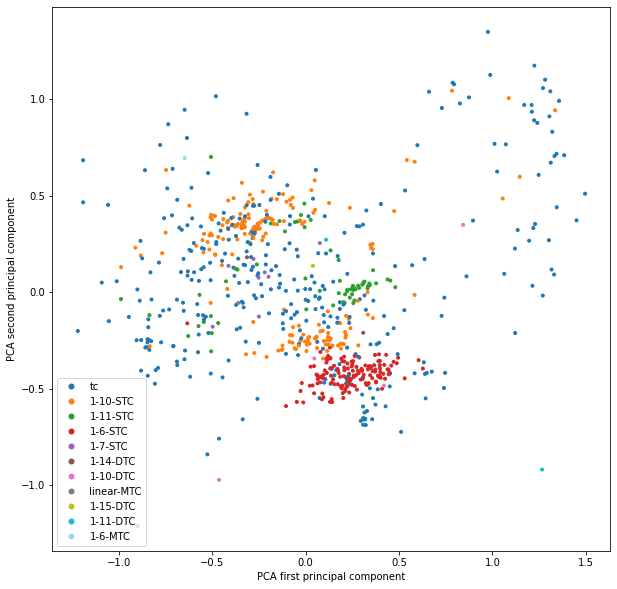

In [146]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train_numbers_for_colours, marker='.', cmap='tab20')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
ax.legend(*sc.legend_elements())

lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), mec="none",
                        label=inv_categories[i], ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(ys_train_numbers_for_colours)]

ax.legend(handles=handles)

### Initialize grids for different regression techniques - doesn't work from here on

In [130]:
knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'model': [SVR()],
        'model__C' : [0.1, 1.0, 10.0],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : [3],
        'model__gamma': ['scale'],
    }
]

rfr_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators' : [20],
        'model__criterion' : ['squared_error', 'absolute_error'],
        'model__max_features': ['sqrt', 'log2'],
        'model__min_samples_split' : [5, 10],
        'model__min_samples_leaf': [1, 4]
    }
]

In [131]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

In [133]:
# make sure data preprocessing (PCA here) is run inside CV to avoid data leakage
pipe = Pipeline(
    steps = (
        ('pca', PCA(num_pca_components)),
        ('model', 'passthrough')
    )
)

result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)
    
print(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

GridSearchCV(estimator=Pipeline(steps=(('pca', PCA(n_components=60)),
                                       ('model', 'passthrough'))),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_features='sqrt',
                                                          min_samples_split=5,
                                                          n_estimators=20)],
                          'model__criterion': ['squared_error',
                                               'absolute_error'],
                          'model__max_features': ['sqrt', 'log2'],
                          'model__min_samples_leaf': [1, 4],
                          'model__min_samples_split': [5, 10],
                          'model__n_estimators': [20]}],
             scoring='r2', verbose=1)


/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

### K Nearest Neighbors


In [119]:
result_list[0].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__leaf_size,param_model__n_neighbors,param_model__p,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.113534,0.003668,0.000341,0.000039,"KNeighborsRegressor(algorithm='ball_tree', lea...",ball_tree,15,5,1,uniform,{'model': KNeighborsRegressor(algorithm='ball_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
26,0.118582,0.007498,0.000412,0.000150,"KNeighborsRegressor(algorithm='ball_tree', lea...",kd_tree,30,5,2,uniform,{'model': KNeighborsRegressor(algorithm='ball_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
27,0.114886,0.005044,0.000729,0.000693,"KNeighborsRegressor(algorithm='ball_tree', lea...",kd_tree,30,5,2,distance,{'model': KNeighborsRegressor(algorithm='ball_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
28,0.115211,0.008564,0.000401,0.000107,"KNeighborsRegressor(algorithm='ball_tree', lea...",kd_tree,30,10,1,uniform,{'model': KNeighborsRegressor(algorithm='ball_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
29,0.111603,0.002886,0.000327,0.000029,"KNeighborsRegressor(algorithm='ball_tree', lea...",kd_tree,30,10,1,distance,{'model': KNeighborsRegressor(algorithm='ball_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


### SVM

In [120]:
result_list[1].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__degree,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.166612,0.015633,0.000468,0.000248,"SVR(C=0.1, kernel='linear')",0.1,3,scale,linear,"{'model': SVR(C=0.1, kernel='linear'), 'model_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.131305,0.014927,0.000277,0.000034,"SVR(C=0.1, kernel='linear')",0.1,3,scale,poly,"{'model': SVR(C=0.1, kernel='linear'), 'model_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,0.110822,0.004008,0.000391,0.000128,"SVR(C=0.1, kernel='linear')",0.1,3,scale,rbf,"{'model': SVR(C=0.1, kernel='linear'), 'model_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,0.111200,0.003109,0.000419,0.000045,"SVR(C=0.1, kernel='linear')",0.1,3,scale,sigmoid,"{'model': SVR(C=0.1, kernel='linear'), 'model_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,0.108620,0.002622,0.000350,0.000070,"SVR(C=0.1, kernel='linear')",1.0,3,scale,linear,"{'model': SVR(C=0.1, kernel='linear'), 'model_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


### Random Forest

In [121]:
result_list[2].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__criterion,param_model__max_features,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.159976,0.010025,0.000417,0.000040,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,1,5,20,{'model': RandomForestRegressor(max_features='...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.134472,0.014082,0.000636,0.000594,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,1,10,20,{'model': RandomForestRegressor(max_features='...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,0.121336,0.009693,0.000418,0.000121,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,4,5,20,{'model': RandomForestRegressor(max_features='...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,0.118261,0.005978,0.000504,0.000179,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,4,10,20,{'model': RandomForestRegressor(max_features='...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,0.110499,0.003842,0.000617,0.000327,"RandomForestRegressor(max_features='sqrt', min...",squared_error,log2,1,5,20,{'model': RandomForestRegressor(max_features='...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


### Evaluation

In [122]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')

passthrough



AttributeError: 'str' object has no attribute 'predict'

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/klara/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  Fi

UnicodeDecodeError: ignored